<a href="https://colab.research.google.com/github/its-tayo/msc_research/blob/main/RealLifeViolence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This study introduces an efficient method for detecting violence in real-time through CCTV using deep learning. Leveraging the Real-Life Violence Situations (RLVS) dataset of 2000 videos, focus was on MobileNet-v2 combined with a Bi-directional LSTM architecture. Pre-trained on ImageNet and fine-tuned for violence detection, this model achieved a notable 92.25% accuracy. Its blend of MobileNet-v2's efficiency and Bi-LSTM's temporal processing demonstrates significant potential in enhancing real-time surveillance systems for improved public safety. This research contributes to the development of more advanced and reliable surveillance systems, enhancing public safety through efficient real-time monitoring of violent behaviours.

# 0. Setup Base Requirements



## 0.1. Import Required Libraries

This cell imports essential Python libraries and modules necessary for video processing, model creation, training, and evaluation. Libraries like OpenCV (cv2), NumPy, TensorFlow, Keras, and Matplotlib are imported to handle various tasks such as data manipulation, neural network construction, and visualization.

In [1]:
import os
import time
import json
import random
import datetime as dt

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, GlobalAveragePooling2D, MaxPooling3D, Flatten, Dense, BatchNormalization, Activation, Dropout, TimeDistributed, LSTM, Bidirectional

%matplotlib inline

## 0.2. Define Constants and Paths

In this cell we initialize various constants and file paths. The `seed_constant` ensures reproducibility across runs. We define `default_batch_size`, and the dimensions of images (`image_height`, `image_width`) to standardize inputs. Paths like `models_path`, `videos_path`, etc., specify locations for storing models, datasets, and results. Finally, we set seeds for random number generation in `random`, `numpy`, and `tensorflow` to maintain consistency in results.

In [ ]:
# seed_constant = 42
# default_batch_size = 32
# image_height, image_width = 64, 64
# models_path = "../dataset/models"
# histories_path = "../dataset/histories"
# videos_path = "../dataset/violence_dataset"

# random.seed(seed_constant)
# np.random.seed(seed_constant)
# tf.random.set_seed(seed_constant)

In [2]:
seed_constant = 42
default_batch_size = 32
image_height, image_width = 64, 64
models_path = "/content/drive/MyDrive/msc/models"
histories_path = "/content/drive/MyDrive/msc/histories"
videos_path = "/content/drive/MyDrive/msc/violence_dataset"

random.seed(seed_constant)
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## 0.3. Mount Google Drive
In this cell, Google Drive is mounted to access the video dataset stored there. It uses the google.colab library to integrate the Colab environment with Google Drive, allowing direct access to files and datasets.

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# 1. Data Loading and Preparation

## 1.1. VideoDataLoader Class

This cell defines the `VideoDataLoader` class, a utility for loading and processing video data for deep learning tasks. It supports configurable parameters such as frame count, frame size, and batch size. The class handles operations like reading video files, extracting & resizing frames, color adjustments, and splitting & batching the data for model training or testing.

In [4]:
class VideoDataLoader:
  def __init__(self, dataset_dir, frame_count=16, frame_size=(image_width, image_height), batch_size=default_batch_size, color_mode="grayscale", data_mode="3D"):
    # Initialization of the data loader with configurable parameters
    self.dataset_dir = dataset_dir
    self.frame_count = frame_count
    self.frame_size = frame_size
    self.batch_size = batch_size
    self.color_mode = color_mode
    self.data_mode = data_mode
    self.classes = self._get_classes() # Retrieve class names from the dataset directory
    self.class_to_label = {cls: idx for idx, cls in enumerate(self.classes)} # Create a mapping from class names to numerical labels

  def _get_classes(self):
    # Private method to get class names from the dataset directory
    return [folder for folder in os.listdir(self.dataset_dir) if os.path.isdir(os.path.join(self.dataset_dir, folder))]

  def _get_video_paths_and_labels(self):
    # Private method to get paths and labels of videos
    all_videos, labels = [], []

    for class_name in self.classes:
      class_path = os.path.join(self.dataset_dir, class_name) # Path to the folder of the current class
      videos = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi'))] # List all video files in the class folder
      all_videos += videos # Append video paths
      labels += [self.class_to_label[class_name]] * len(videos) # Append corresponding label for each video

    return all_videos, labels

  def _process_video(self, video_path):
    # Private method to process and extract frames from a single video
    frames = [] # List to store extracted frames

    cap = cv2.VideoCapture(video_path) # Initialize video capture
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total number of frames in the video

    frame_ids = np.linspace(0, total_frames-1, self.frame_count, dtype=int) # Compute indices of frames to capture

    for frame_id in frame_ids:
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id) # Set the current frame position
      ret, frame = cap.read() # Read the frame

      if not ret:
        if frames: 
          frame = frames[-1].copy() # duplicate last frame if total frames in video is less than frame_count
        else:
          break

      frame = cv2.resize(frame, self.frame_size) # Resize the frame to the specified dimensions

      if self.color_mode == "grayscale":
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = np.expand_dims(frame, axis=-1)
      elif self.color_mode == "rgb":
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      frame = frame / 255.0 # Normalize pixel values to the range [0, 1]
      frames.append(frame) # Add the processed frame to the list
        
    cap.release() # Release the video capture object

    while len(frames) < self.frame_count: # If fewer frames were captured than needed, duplicate the last frame
        frames.append(frames[-1].copy())

    return np.stack(frames, axis=0)

  def __call__(self):
    # Method to make the class instance callable, yielding batches of processed video data
    video_paths, labels = self._get_video_paths_and_labels() # Get paths and labels of all videos
    data = list(zip(video_paths, labels))
    np.random.shuffle(data) # Shuffle the data to ensure randomness

    X, y = [], []  # Lists to store video data and labels
    for video_path, label in data:
      video = self._process_video(video_path) # Process each video

      if self.data_mode == "2D":
        X.extend(video)
        y.extend([label] * len(video))
      else:
        X.append(video)
        y.append(label)

      if len(X) == self.batch_size: # If the batch size is reached, yield the batch
        yield np.array(X), np.array(y)
        X, y = [], [] # Reset the lists for the next batch

  def split_data(self, test_size=0.2, random_state=seed_constant):
    # Method to split data into training and testing sets
    video_paths, labels = self._get_video_paths_and_labels()
    return train_test_split(video_paths, labels, test_size=test_size, random_state=random_state)

  def load_data(self, video_paths, labels):
    # Method to load data in batches, given specific paths and labels
    while True:
      X, y = [], [] # Lists to store video data and labels
      for video_path, label in zip(video_paths, labels):
        video = self._process_video(video_path) # Process each video

        if self.data_mode == "3D":
          X.append(video)
          y.append(label)
        else:
          X.extend(video)
          y.extend([label] * len(video))

        if len(X) == self.batch_size: # If the batch size is reached, yield the batch
          yield np.array(X), np.array(y)
          X, y = [], [] # Reset the lists for the next batch

## 1.2. Visualize dataset

This cell demonstrates how to use the VideoDataLoader class. It initializes an instance of the class and uses it to load a batch of videos. Then, it visualizes a few frames from each video in the batch to ensure that the data loading process is working correctly.

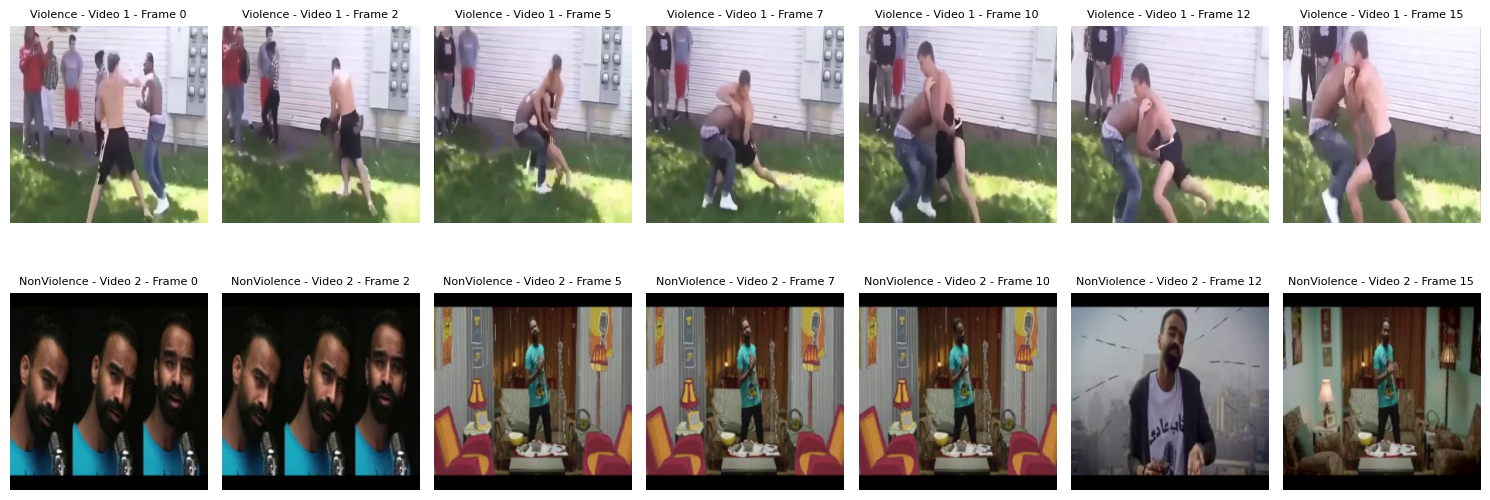

In [ ]:
ncols = 7 # Number of columns for the subplot

# Initialize the data loader with specified parameters
data_loader = VideoDataLoader(videos_path, frame_size=(256, 256), batch_size=2, color_mode="rgb")

# Process one batch of videos and labels
for video_batch, labels_batch in data_loader():
  num_videos = len(video_batch) # Number of videos in the batch

  # Generate evenly spaced frame indices for selection
  selected_frame_indices = np.linspace(0, data_loader.frame_count - 1, ncols, dtype=int)

  # Set up the figure size based on the number of videos
  plt.figure(figsize=(15, num_videos * 3))

  # Iterate over each video and its label
  for i, (video, label) in enumerate(zip(video_batch, labels_batch)):
    class_name = data_loader.classes[label]  # Get class name

    # Plot selected frames for each video
    for j, frame_idx in enumerate(selected_frame_indices):
      plt.subplot(num_videos, ncols, i * ncols + j + 1)
      plt.imshow(video[int(frame_idx)]) # Display the selected frame
      # Set title for each subplot
      plt.title(f'{class_name} - Video {i+1} - Frame {frame_idx}', fontsize=8)
      plt.axis('off') # Hide axis

  plt.tight_layout()
  plt.show()

  break  # To only process one batch for demonstration

## 1.3. Data Exploration: Video Count

The bar chart indicates that our dataset consists of 1000 videos labeled as 'Violence', depicting scenarios with violent actions, and 996 videos labeled as 'NonViolence', showing scenarios without violent actions.

{'Violence': 1000, 'NonViolence': 996}


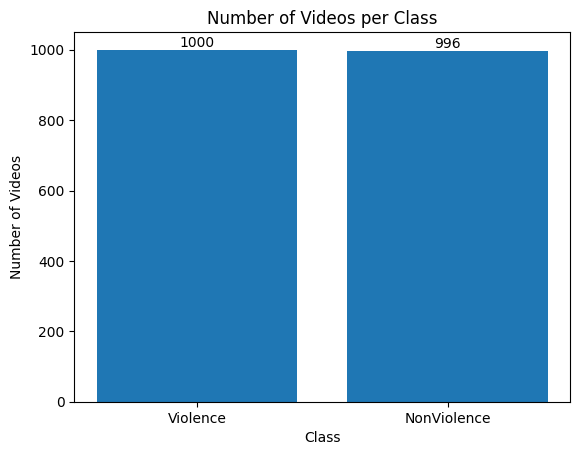

In [ ]:
# data_loader = VideoDataLoader(videos_path, frame_size=(256, 256), batch_size=2, color_mode="rgb")
def plot_video_counts(data_loader):
    video_paths, labels = data_loader._get_video_paths_and_labels()

    # Count videos per class
    class_counts = {class_name: labels.count(label) for class_name, label in data_loader.class_to_label.items()}
    print(class_counts)


    # Bar graph for video counts
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Videos')
    plt.title('Number of Videos per Class')

    # plt.xticks(rotation=90)

    # Annotate each bar with the count
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()

plot_video_counts(data_loader)

# 2. Model Implementation

## 2.1. Base Model: 3D ConvNet

In [ ]:
class BaseModel:
  def __init__(self, name, input_shape, num_classes):
    self.name = name
    self.input_shape = input_shape
    self.num_classes = num_classes

  def build(self):
    model = Sequential(name=self.name)

    # First block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=self.input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))  # Dropout after first block

    # Second block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))  # Dropout after second block

    # Classifier
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))  # Dropout before final classification layer
    model.add(Dense(self.num_classes, activation='softmax'))

    model.summary()

    return model

## 2.2. 3D ConvNet 2

In [ ]:
class Conv3DModel2(BaseModel):
  def build(self):
    model = Sequential(name=self.name)

    # First block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', input_shape=self.input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))  # Dropout after first block

    # Second block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))  # Dropout after second block

    # Third block
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))  # Dropout after third block

    # Classifier
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))  # Dropout before final classification layer
    model.add(Dense(self.num_classes, activation='softmax'))

    model.summary()

    return model

## 2.3. CNN + LSTM

In [ ]:
class CNN_LSTM1(BaseModel):
  def build(self):
    cnn_model = Sequential(name=self.name)

    # First block
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape[1:]))
    cnn_model.add(MaxPooling2D((2, 2)))

    # Second block
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))

    cnn_model.add(Flatten())

    rnn_model = Sequential(name=self.name)
    rnn_model.add(TimeDistributed(cnn_model, input_shape=self.input_shape))
    rnn_model.add(LSTM(50))

    rnn_model.add(Dense(256, activation='relu'))
    rnn_model.add(Dense(self.num_classes, activation='softmax'))

    rnn_model.summary()

    return rnn_model

## 2.4. CNN + LSTM 2

In [ ]:
class CNN_LSTM2(BaseModel):
  def build(self):
    cnn_model = Sequential(name=f"CNN_{self.name}")

    # First block
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape[1:]))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.25))

    # Second block
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))

    # Third block
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())

    rnn_model = Sequential(name=f"LSTM_{self.name}")
    rnn_model.add(TimeDistributed(cnn_model, input_shape=self.input_shape))
    rnn_model.add(LSTM(100))
    rnn_model.add(Dropout(0.5))

    rnn_model.add(Dense(512, activation='relu'))
    rnn_model.add(Dropout(0.5))
    rnn_model.add(Dense(self.num_classes, activation='softmax'))

    cnn_model.summary()
    rnn_model.summary()

    return rnn_model

## 2.5. CNN + Bi-directional LSTM

In [ ]:
class CNN_BiLSTM(BaseModel):
  def build(self):
    cnn_model = Sequential(name=f"CNN_{self.name}")

    # First block
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape[1:]))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.25))

    # Second block
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))

    # Third block
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())

    rnn_model = Sequential(name=f"LSTM_{self.name}")
    rnn_model.add(TimeDistributed(cnn_model, input_shape=self.input_shape))
    rnn_model.add(Bidirectional(LSTM(100)))
    rnn_model.add(Dropout(0.5))

    rnn_model.add(Dense(512, activation='relu'))
    rnn_model.add(Dropout(0.5))
    rnn_model.add(Dense(self.num_classes, activation='softmax'))

    cnn_model.summary()
    rnn_model.summary()

    return rnn_model

## 2.6. MobileNetV2 + Bi-directional LSTM

In [ ]:
class MobileNetV2_LSTM(BaseModel):
  def build(self):
    # Load pre-trained MobileNetV2 model
    mobilenetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape[1:])

    # Fine-tuning the top layers
    for layer in mobilenetV2.layers[:-40]:
      layer.trainable = False

    rnn_model = Sequential(name=f"LSTM_{self.name}")
    rnn_model.add(TimeDistributed(mobilenetV2, input_shape=self.input_shape))
    rnn_model.add(Dropout(0.25))
    rnn_model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    rnn_model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(256,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(128,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(64,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(32,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(self.num_classes, activation='softmax'))

    mobilenetV2.summary()
    rnn_model.summary()

    return rnn_model

In [ ]:
class MobileNetV2_LSTM_Last20(BaseModel):
  def build(self):
    # Load pre-trained MobileNetV2 model
    mobilenetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape[1:])

    # Fine-tuning the top layers
    for layer in mobilenetV2.layers[:-20]:
      layer.trainable = False

    rnn_model = Sequential(name=f"LSTM_{self.name}")
    rnn_model.add(TimeDistributed(mobilenetV2, input_shape=self.input_shape))
    rnn_model.add(Dropout(0.25))
    rnn_model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    rnn_model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(256,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(128,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(64,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(32,activation='relu'))
    rnn_model.add(Dropout(0.25))

    rnn_model.add(Dense(self.num_classes, activation='softmax'))

    mobilenetV2.summary()
    rnn_model.summary()

    return rnn_model

# 3. Model Training And Evaluation

## 3.1. Define Training Function

This function, train_model, handles the training of a given model. It includes callbacks for early stopping, learning rate scheduling, and model checkpoint saving. The function compiles the model, fits it to the training data, and returns the trained model along with its training history.

In [ ]:
def train_model(model, model_name, data_loader, train_videos, train_labels, test_videos, test_labels, initial_lr=0.0001, lr_drop=0.1, lr_epochs_drop=10, epochs=20):
  # Early stopping to prevent overfitting
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

  # Step Learning Rate Scheduler
  def scheduler(epoch, lr):
    if epoch < lr_epochs_drop:
      return lr
    else:
      return lr * np.exp(-lr_drop)
  lr_scheduler = LearningRateScheduler(scheduler)

  # Naming the saved model with timestamp
  saved_model_name = f"{model_name}_{dt.datetime.now().strftime('%Y%m%d-%H%M%S')}"

  # Checkpoint saver
  checkpoint_path = f"{models_path}/{saved_model_name}.h5"
  checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy

  # Compute class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
  class_weights = dict(enumerate(class_weights))

  # Tracking start time for training duration
  start_time = time.time()

  # Train the model
  history = model.fit(
      data_loader.load_data(train_videos, train_labels),
      validation_data=data_loader.load_data(test_videos, test_labels),
      steps_per_epoch=len(train_videos) // data_loader.batch_size,
      validation_steps=len(test_videos) // data_loader.batch_size,
      epochs=epochs,
      callbacks=[early_stopping, lr_scheduler, checkpoint],
      class_weight=class_weights
  )

  # Tracking end time of training
  end_time = time.time()

  # Converting training history to a float format and saving
  history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}
  history_path = f"{histories_path}/{saved_model_name}.json"

  with open(history_path, 'w') as f:
      json.dump(history_dict, f)


  print(f"\n\n\n\n\n------------TRAINING SUMMARY: {model_name}------------")
  training_duration = end_time - start_time
  print(f"{training_duration:.2f} seconds")

  return model, history

## 3.2. Define Evaluation Functions

`evaluate_and_plot` is a function for evaluating a trained model on test data and plotting its training history. It computes the model's accuracy and loss on the test set and visualizes the model's training and validation accuracy and loss over epochs.

`predict_and_print_reports` makes predictions on the test dataset, prints a classification report, and displays a confusion matrix.

In [ ]:
def evaluate_and_plot(model, model_name, data_loader, history, test_videos, test_labels):
  # Evaluate the model on the test dataset
  test_data_generator = data_loader.load_data(test_videos, test_labels)
  test_loss, test_acc = model.evaluate(test_data_generator, steps=len(test_videos) // data_loader.batch_size)
  print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

  # Plot training & validation accuracy and loss
  plt.figure(figsize=(12, 4))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'{model_name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.show()

def predict_and_print_reports(model, model_name, data_loader, test_video_paths, test_labels):
  # Record the start time
  start_time = time.time()
  predicted_labels = []

  # Predict labels for each video in test dataset
  for video_path in tqdm(test_video_paths, desc='Evaluating videos'):
    video_data = data_loader._process_video(video_path)
    video_data = np.expand_dims(video_data, axis=0)  # Add batch dimension for prediction
    predictions = model.predict(video_data, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_labels.extend(predicted_class)

  # Record the end time
  end_time = time.time()

  # Print classification report
  print(classification_report(test_labels, predicted_labels))

  # Plot the confusion matrix
  plt.figure(dpi=200, figsize=(10,15))
  ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=data_loader.classes, cmap="Blues")
  plt.title(f"{model_name} Confusion Matrix")
  plt.show()

  print(f"\n\n\n\n\n------------INFERENCE SUMMARY: {model_name}------------")
  inference_duration = end_time - start_time
  print(f"{inference_duration:.2f} seconds")

## 3.3. Training And Evaluation Sequence

### 3.3.1. Base Model

In [ ]:
# Initialize the data loader
model_name = "Base_Model"
data_loader = VideoDataLoader(videos_path, batch_size=8)
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 1)

# Train and evaluate the Conv3DModel1
base_model = BaseModel(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
base_model, base_model_history = train_model(
    base_model,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "Base_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 64, 64, 32)    896       
                                                                 
 batch_normalization (Batch  (None, 16, 64, 64, 32)    128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 16, 64, 64, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 32, 32, 32)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 32, 32, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 32, 32, 64)     5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 1436s 7s/step - loss: 13.5285 - accuracy: 0.6545 - val_loss: 2.9737 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.7996
Epoch 2: val_loss improved from 2.97366 to 1.06372, saving model to /content/drive/MyDrive/msc/models/Base_Model_20231205-210403.h5
199/199 [==============================] - 711s 4s/step - loss: 0.4571 - accuracy: 0.7996 - val_loss: 1.0637 - val_accuracy: 0.5975 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8317
Epoch 3: val_loss improved from 1.06372 to 0.50386, saving model to /content/drive/MyDrive/msc/models/Base_Model_20231205-210403.h5
199/199 [==============================] - 708s 4s/step - loss: 0.4046 - accuracy: 0.8317 - val_loss: 0.5039 - val_accuracy: 0.7875 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8417
Epo

------------EVALUATING MODEL: Base_Model------------
50/50 [==============================] - 143s 3s/step - loss: 0.5039 - accuracy: 0.7875
Test accuracy: 0.7875000238418579, Test loss: 0.5038543939590454


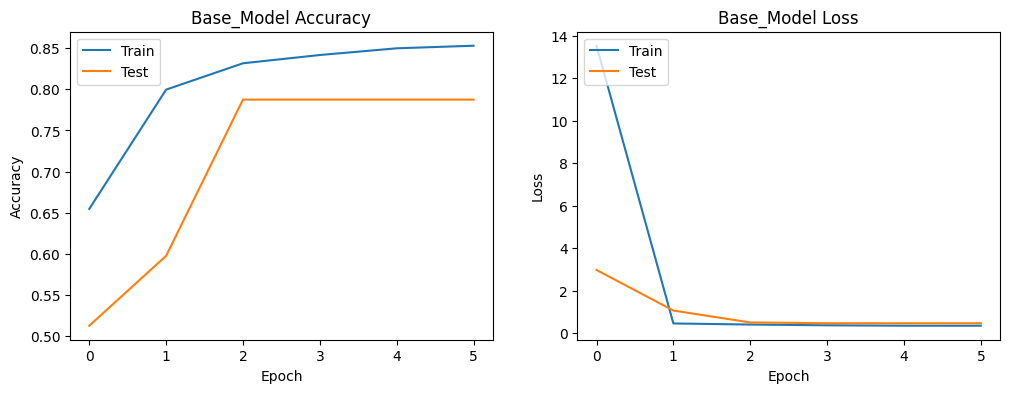






------------CLASSIFICATION REPORT & CONFUSION MATRIX: Base_Model------------


Evaluating videos: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s]

              precision    recall  f1-score   support

           0       0.87      0.67      0.75       195
           1       0.74      0.90      0.81       205

    accuracy                           0.79       400
   macro avg       0.80      0.78      0.78       400
weighted avg       0.80      0.79      0.78       400



<Figure size 2000x3000 with 0 Axes>

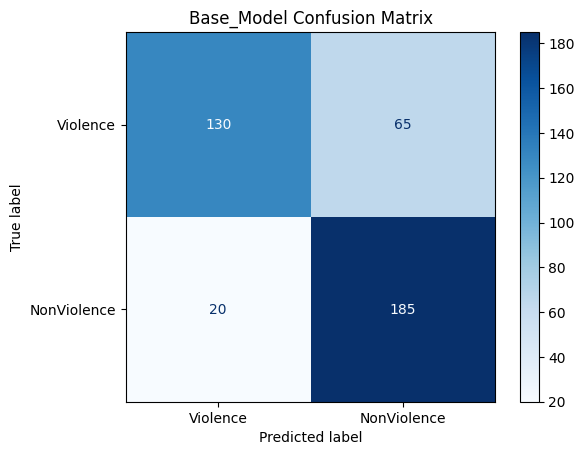






------------INFERENCE SUMMARY: Base_Model------------
165.13 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(base_model, model_name, data_loader, base_model_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(base_model, model_name, data_loader, test_videos, test_labels)

### 3.3.3. 3D ConvNet 2

In [ ]:
# Initialize the data loader
model_name = "Conv3DModel2"
data_loader = VideoDataLoader(videos_path, batch_size=8)
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 1)

# Train and evaluate the Conv3DModel2
conv3d_model2 = Conv3DModel2(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
conv3d_model2, conv3d_model2_history = train_model(
    conv3d_model2,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "Conv3DModel2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 64, 64, 32)    896       
                                                                 
 batch_normalization (Batch  (None, 16, 64, 64, 32)    128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 16, 64, 64, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 32, 32, 32)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 32, 32, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 32, 32, 64)    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 1499s 8s/step - loss: 3.9666 - accuracy: 0.6577 - val_loss: 0.8214 - val_accuracy: 0.5150 - lr: 0.0010
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.4983 - accuracy: 0.7619
Epoch 2: val_loss did not improve from 0.82140
199/199 [==============================] - 741s 4s/step - loss: 0.4983 - accuracy: 0.7619 - val_loss: 1.0492 - val_accuracy: 0.5375 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8097
Epoch 3: val_loss improved from 0.82140 to 0.44574, saving model to /content/drive/MyDrive/msc/models/Conv3DModel2_20231206-091150.h5
199/199 [==============================] - 743s 4s/step - loss: 0.4175 - accuracy: 0.8097 - val_loss: 0.4457 - val_accuracy: 0.7950 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8247
Epoch 4: val_loss improved from 0.44574 to 0.44465, saving model to /content/drive/MyDr

------------EVALUATING MODEL: Conv3DModel2------------
50/50 [==============================] - 150s 3s/step - loss: 0.4447 - accuracy: 0.8075
Test accuracy: 0.8075000047683716, Test loss: 0.4446529150009155


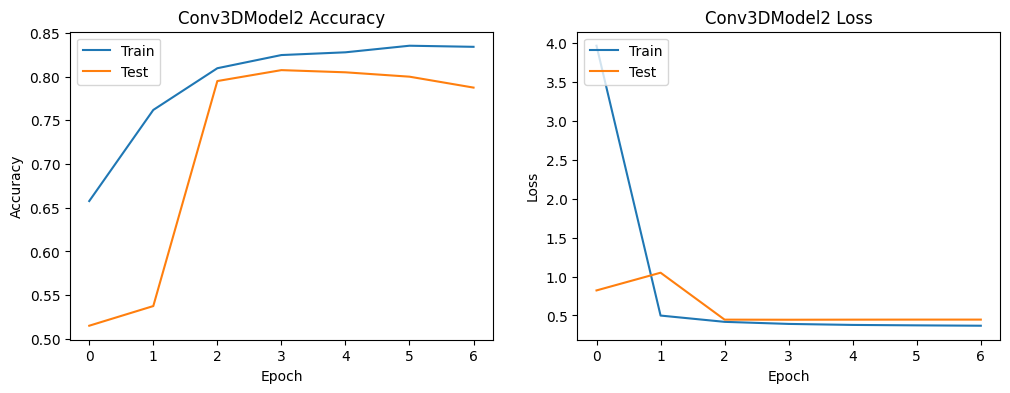






------------CLASSIFICATION REPORT & CONFUSION MATRIX: Conv3DModel2------------


Evaluating videos: 100%|██████████| 400/400 [02:53<00:00,  2.31it/s]

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       195
           1       0.80      0.83      0.82       205

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



<Figure size 2000x3000 with 0 Axes>

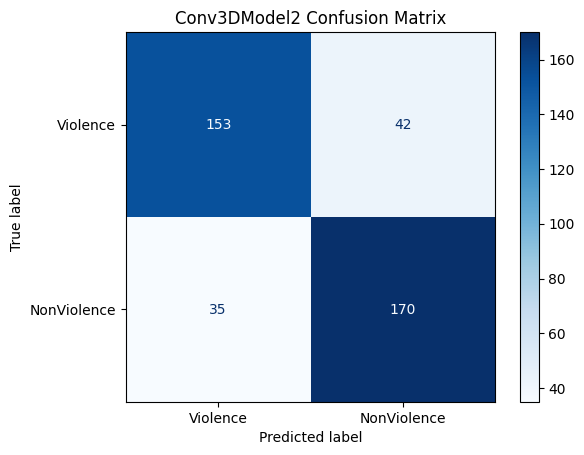






------------INFERENCE SUMMARY: Conv3DModel2------------
173.27 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(conv3d_model2, model_name, data_loader, conv3d_model2_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(conv3d_model2, model_name, data_loader, test_videos, test_labels)

### 3.3.4. CNN + LSTM

In [ ]:
# Initialize the data loader
model_name = "CNN_LSTM1"
data_loader = VideoDataLoader(videos_path, batch_size=8)
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 1)

# Train and evaluate the CNN_LSTM1
cnn_lstm1 = CNN_LSTM1(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
cnn_lstm1, cnn_lstm1_history = train_model(
    cnn_lstm1,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "CNN_LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 12544)         18816     
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 50)                2519000   
                                                                 
 dense_2 (Dense)             (None, 256)               13056     
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2551386 (9.73 MB)
Trainable params: 2551386 (9.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________





------------TRAINING MODEL: CNN_LSTM1------------
Epoch 1/50
199/199 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.7475
Epoch 2: val_loss improved from 0.62704 to 0.54716, saving model to /content/drive/MyDrive/msc/models/CNN_LSTM1_20231206-110812.h5
199/199 [==============================] - 752s 4s/step - loss: 0.4986 - accuracy: 0.7475 - val_loss: 0.5472 - val_accuracy: 0.7200 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8461
Epoch 3: val_loss improved from 0.54716 to 0.49830, saving model to /content/drive/MyDrive/msc/models/CNN_LSTM1_20231206-110812.h5
199/199 [==============================] - 754s 4s/step - loss: 0.3461 - accuracy: 0.8461 - val_loss: 0.4983 - val_accuracy: 0.7800 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8819
Epoch 4: val_loss improved from 0.49830 to 0.49220, saving model to /content/drive/MyDrive/msc/models/CNN_LSTM1_20231206-110812.h5
199/199 [=======================

------------EVALUATING MODEL: CNN_LSTM1------------
50/50 [==============================] - 149s 3s/step - loss: 0.4922 - accuracy: 0.8050
Test accuracy: 0.8050000071525574, Test loss: 0.492201030254364


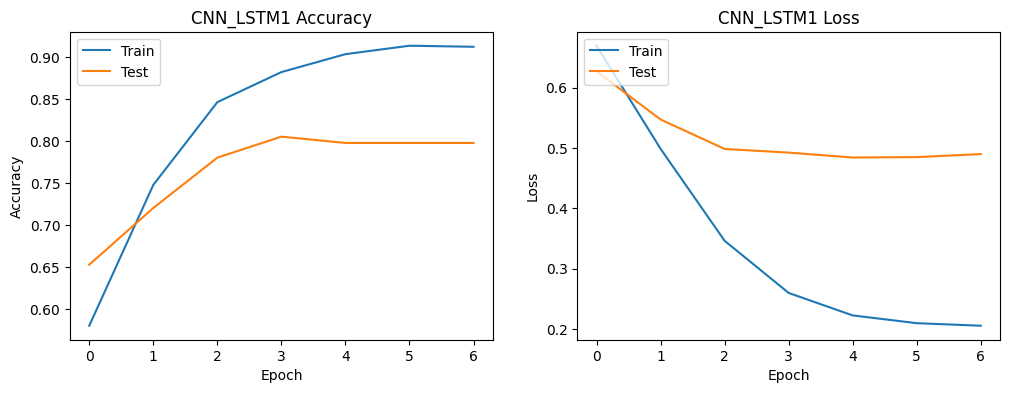






------------CLASSIFICATION REPORT & CONFUSION MATRIX: CNN_LSTM1------------


Evaluating videos: 100%|██████████| 400/400 [02:51<00:00,  2.34it/s]

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       195
           1       0.88      0.72      0.79       205

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.80       400
weighted avg       0.82      0.81      0.80       400



<Figure size 2000x3000 with 0 Axes>

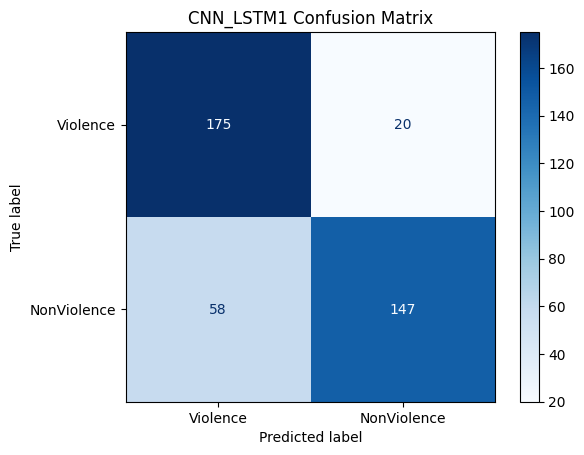






------------INFERENCE SUMMARY: CNN_LSTM1------------
171.28 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(cnn_lstm1, model_name, data_loader, cnn_lstm1_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(cnn_lstm1, model_name, data_loader, test_videos, test_labels)

### 3.3.5. CNN + LSTM 2

In [ ]:
# Initialize the data loader
model_name = "CNN_LSTM2"
data_loader = VideoDataLoader(videos_path, batch_size=8)
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 1)

# Train and evaluate the CNN_LSTM2
cnn_lstm2 = CNN_LSTM2(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
cnn_lstm2, cnn_lstm2_history = train_model(
    cnn_lstm2,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "CNN_CNN_LSTM2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 128)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.5609
Epoch 2: val_loss improved from 0.68135 to 0.67296, saving model to /content/drive/MyDrive/msc/models/CNN_LSTM2_20231206-131522.h5
199/199 [==============================] - 734s 4s/step - loss: 0.6485 - accuracy: 0.5609 - val_loss: 0.6730 - val_accuracy: 0.5725 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.6489
Epoch 3: val_loss improved from 0.67296 to 0.62354, saving model to /content/drive/MyDrive/msc/models/CNN_LSTM2_20231206-131522.h5
199/199 [==============================] - 733s 4s/step - loss: 0.5950 - accuracy: 0.6489 - val_loss: 0.6235 - val_accuracy: 0.6300 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.7098
Epoch 4: val_loss did not improve from 0.62354
199/199 [==============================] - 735s 4s/step - loss: 0.5304 - accuracy: 0.7098 - val_loss: 0.6282 - val_a

------------EVALUATING MODEL: CNN_LSTM2------------
50/50 [==============================] - 150s 3s/step - loss: 0.6282 - accuracy: 0.6350
Test accuracy: 0.6349999904632568, Test loss: 0.6282238364219666


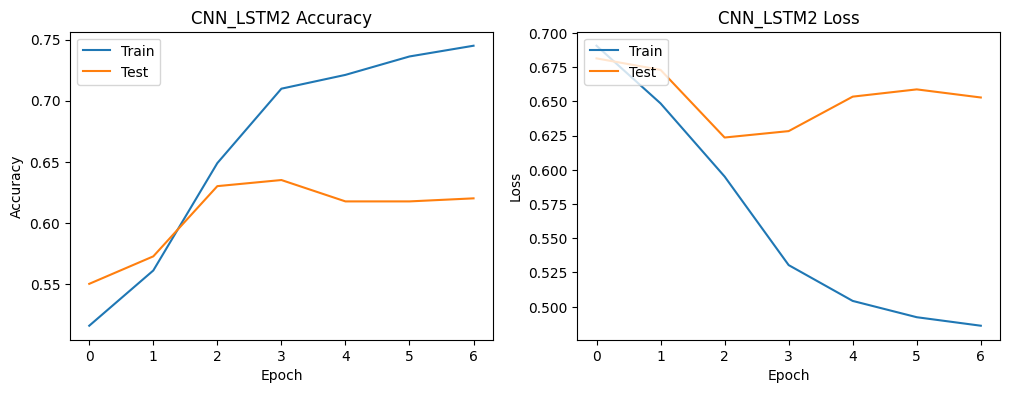






------------CLASSIFICATION REPORT & CONFUSION MATRIX: CNN_LSTM2------------


Evaluating videos: 100%|██████████| 400/400 [02:53<00:00,  2.31it/s]

              precision    recall  f1-score   support

           0       0.87      0.30      0.44       195
           1       0.59      0.96      0.73       205

    accuracy                           0.64       400
   macro avg       0.73      0.63      0.59       400
weighted avg       0.72      0.64      0.59       400



<Figure size 2000x3000 with 0 Axes>

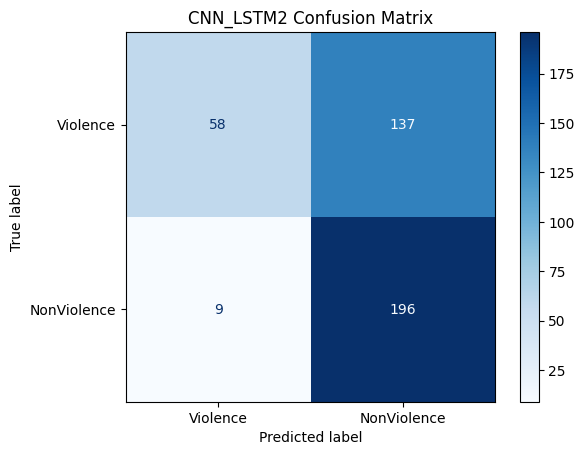






------------INFERENCE SUMMARY: CNN_LSTM2------------
173.36 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(cnn_lstm2, model_name, data_loader, cnn_lstm2_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(cnn_lstm2, model_name, data_loader, test_videos, test_labels)

### 3.3.6. CNN + Bi-directional LSTM

In [ ]:
# Initialize the data loader
model_name = "CNN_BiLSTM"
data_loader = VideoDataLoader(videos_path, batch_size=8)
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 1)

# Train and evaluate the CNN_BiLSTM
cnn_biLstm = CNN_BiLSTM(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
cnn_biLstm, cnn_biLstm_history = train_model(
    cnn_biLstm,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "CNN_CNN_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.5484
Epoch 2: val_loss improved from 0.69068 to 0.65012, saving model to /content/drive/MyDrive/msc/models/CNN_BiLSTM_20231206-145958.h5
199/199 [==============================] - 735s 4s/step - loss: 0.6576 - accuracy: 0.5484 - val_loss: 0.6501 - val_accuracy: 0.7275 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.6947
Epoch 3: val_loss improved from 0.65012 to 0.57126, saving model to /content/drive/MyDrive/msc/models/CNN_BiLSTM_20231206-145958.h5
199/199 [==============================] - 746s 4s/step - loss: 0.5673 - accuracy: 0.6947 - val_loss: 0.5713 - val_accuracy: 0.7300 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7475
Epoch 4: val_loss improved from 0.57126 to 0.56780, saving model to /content/drive/MyDrive/msc/models/CNN_BiLSTM_20231206-145958.h5
199/199 [====================

------------EVALUATING MODEL: CNN_BiLSTM------------
50/50 [==============================] - 151s 3s/step - loss: 0.5634 - accuracy: 0.7425
Test accuracy: 0.7425000071525574, Test loss: 0.5633628368377686


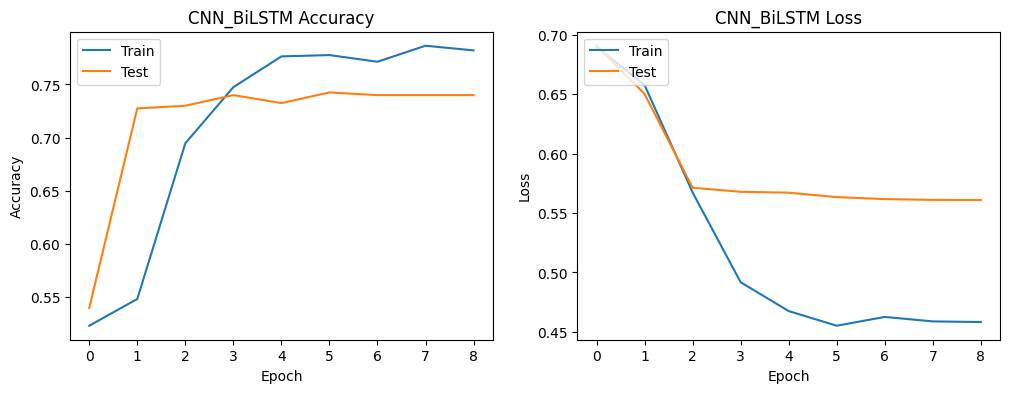






------------CLASSIFICATION REPORT & CONFUSION MATRIX: CNN_BiLSTM------------


Evaluating videos: 100%|██████████| 400/400 [02:56<00:00,  2.26it/s]

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       195
           1       0.72      0.82      0.77       205

    accuracy                           0.74       400
   macro avg       0.75      0.74      0.74       400
weighted avg       0.75      0.74      0.74       400



<Figure size 2000x3000 with 0 Axes>

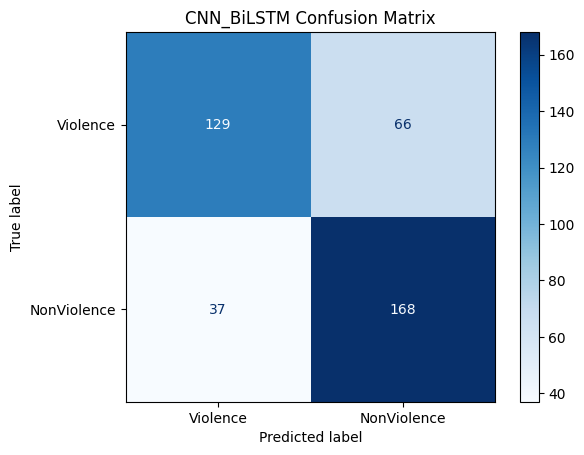






------------INFERENCE SUMMARY: CNN_BiLSTM------------
177.00 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(cnn_biLstm, model_name, data_loader, cnn_biLstm_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(cnn_biLstm, model_name, data_loader, test_videos, test_labels)

### 3.3.7. MobileNetV2 + Bi-directional LSTM

In [ ]:
# Initialize the data loader
model_name = "MobileNetV2_BiLSTM"
data_loader = VideoDataLoader(videos_path, batch_size=8, frame_size=(128,128), color_mode="rgb")
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 3)

# Train and evaluate the MobileNetV2_BiLSTM
mobileNetV2LSTM = MobileNetV2_LSTM(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
mobileNetV2LSTM, mobileNetV2LSTM_history = train_model(
    mobileNetV2LSTM,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 835s 4s/step - loss: 0.6112 - accuracy: 0.6646 - val_loss: 0.8946 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.8241
Epoch 2: val_loss improved from 0.89459 to 0.42017, saving model to /content/drive/MyDrive/msc/models/MobileNetV2_BiLSTM_20231206-170313.h5
199/199 [==============================] - 771s 4s/step - loss: 0.4381 - accuracy: 0.8241 - val_loss: 0.4202 - val_accuracy: 0.8375 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8838
Epoch 3: val_loss did not improve from 0.42017
199/199 [==============================] - 774s 4s/step - loss: 0.3036 - accuracy: 0.8838 - val_loss: 0.5019 - val_accuracy: 0.7750 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9240
Epoch 4: val_loss improved from 0.42017 to 0.36699, saving model to /content/drive

------------EVALUATING MODEL: MobileNetV2_BiLSTM------------
50/50 [==============================] - 152s 3s/step - loss: 0.2404 - accuracy: 0.9200
Test accuracy: 0.9200000166893005, Test loss: 0.24039140343666077


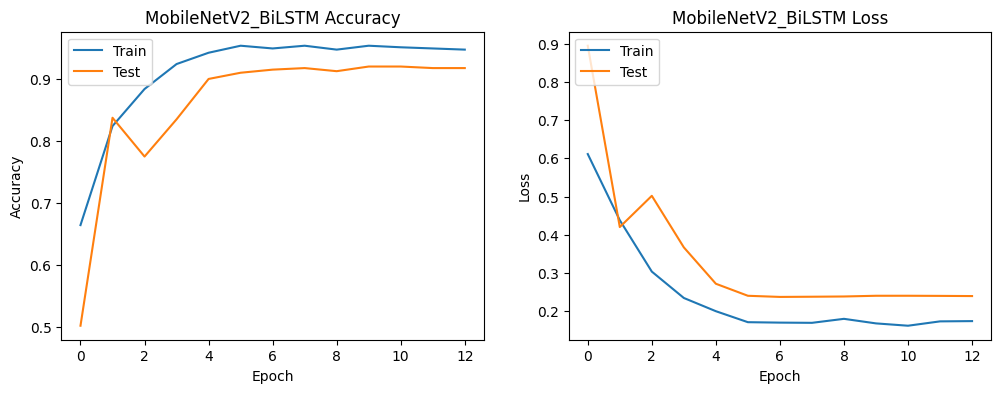






------------CLASSIFICATION REPORT & CONFUSION MATRIX: MobileNetV2_BiLSTM------------


Evaluating videos: 100%|██████████| 400/400 [02:58<00:00,  2.24it/s]

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       195
           1       0.94      0.90      0.92       205

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



<Figure size 2000x3000 with 0 Axes>

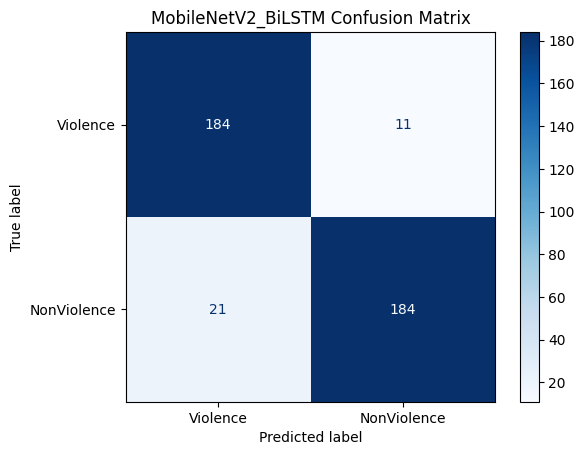






------------INFERENCE SUMMARY: MobileNetV2_BiLSTM------------
178.34 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(mobileNetV2LSTM, model_name, data_loader, mobileNetV2LSTM_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(mobileNetV2LSTM, model_name, data_loader, test_videos, test_labels)

### 3.3.8. MobileNetV2 + Bi-directional LSTM - 8 frames

In [ ]:
# Initialize the data loader
model_name = "MobileNetV2_LSTM2_8_Frames"
data_loader = VideoDataLoader(videos_path, batch_size=8, frame_count=8, frame_size=(128,128), color_mode="rgb")
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 3)

# Train and evaluate the MobileNetV2_LSTM2_8_Frames
mobileNetV2LSTM2_8F = MobileNetV2_LSTM(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
mobileNetV2LSTM2_8F, mobileNetV2LSTM2_8F_history = train_model(
    mobileNetV2LSTM2_8F,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 380s 2s/step - loss: 0.6255 - accuracy: 0.6702 - val_loss: 0.5589 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8034
Epoch 2: val_loss improved from 0.55886 to 0.46318, saving model to /content/drive/MyDrive/msc/models/MobileNetV2_LSTM2_8_Frames_20231129-070220.h5
199/199 [==============================] - 356s 2s/step - loss: 0.4656 - accuracy: 0.8034 - val_loss: 0.4632 - val_accuracy: 0.7875 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8706
Epoch 3: val_loss did not improve from 0.46318
199/199 [==============================] - 355s 2s/step - loss: 0.3459 - accuracy: 0.8706 - val_loss: 0.5426 - val_accuracy: 0.7475 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9121
Epoch 4: val_loss improved from 0.46318 to 0.37997, saving model to /conte

------------EVALUATING MODEL: MobileNetV2_LSTM2_8_Frames------------
50/50 [==============================] - 72s 1s/step - loss: 0.2347 - accuracy: 0.9250
Test accuracy: 0.925000011920929, Test loss: 0.23467391729354858


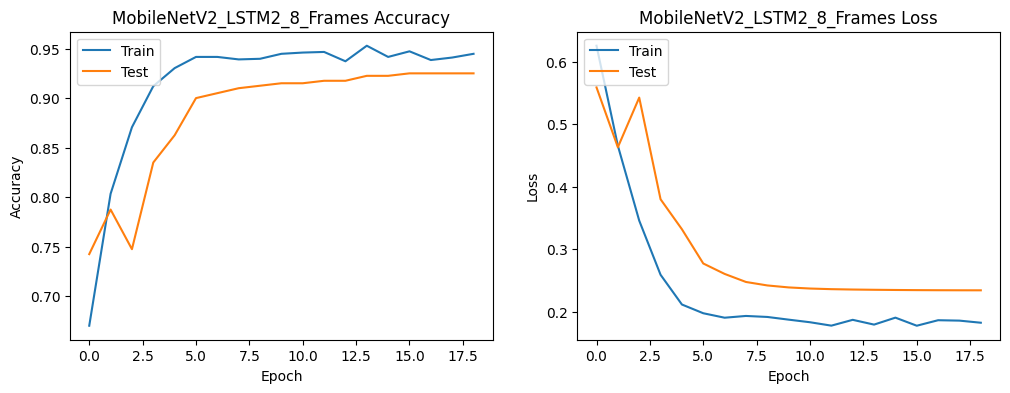






------------CLASSIFICATION REPORT & CONFUSION MATRIX: MobileNetV2_LSTM2_8_Frames------------


Evaluating videos: 100%|██████████| 400/400 [01:38<00:00,  4.07it/s]

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       195
           1       0.94      0.92      0.93       205

    accuracy                           0.93       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.93      0.93      0.93       400



<Figure size 2000x3000 with 0 Axes>

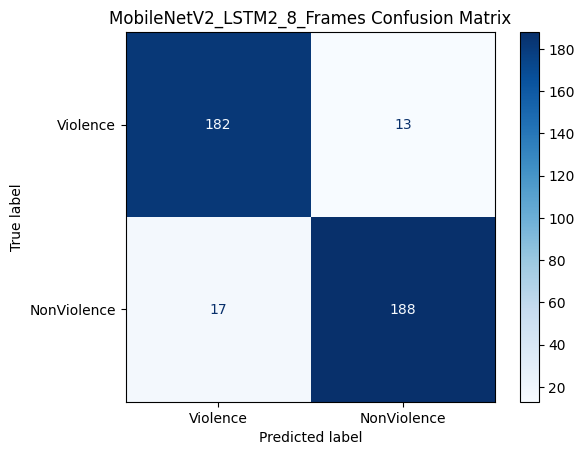

In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(mobileNetV2LSTM2_8F, model_name, data_loader, mobileNetV2LSTM2_8F_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(mobileNetV2LSTM2_8F, model_name, data_loader, test_videos, test_labels)

### 3.3.9. MobileNetV2 + Bi-directional LSTM - Last 20 Layers

In [ ]:
# Initialize the data loader
model_name = "MobileNetV2_LSTM_Last20"
data_loader = VideoDataLoader(videos_path, batch_size=8, frame_size=(128,128), color_mode="rgb")
train_videos, test_videos, train_labels, test_labels = data_loader.split_data()

# Define the input shape for models
input_shape = (data_loader.frame_count, *data_loader.frame_size, 3)

# Train and evaluate the MobileNetV2_LSTM_Last20
mobileNetV2LSTM20 = MobileNetV2_LSTM_Last20(name=model_name, input_shape=input_shape, num_classes=len(data_loader.classes)).build()

print(f"\n\n\n\n\n------------TRAINING MODEL: {model_name}------------")
mobileNetV2LSTM20, mobileNetV2LSTM20_history = train_model(
    mobileNetV2LSTM20,
    model_name,
    data_loader,
    train_videos,
    train_labels,
    test_videos,
    test_labels,
    initial_lr=0.001,
    lr_drop=1,
    lr_epochs_drop=1,
    epochs=50
    )

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 801s 4s/step - loss: 0.6439 - accuracy: 0.6156 - val_loss: 0.6968 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8109
Epoch 2: val_loss did not improve from 0.69682
199/199 [==============================] - 757s 4s/step - loss: 0.4390 - accuracy: 0.8109 - val_loss: 0.8707 - val_accuracy: 0.6325 - lr: 3.6788e-04
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9052
Epoch 3: val_loss improved from 0.69682 to 0.31105, saving model to /content/drive/MyDrive/msc/models/MobileNetV2_LSTM_Last20_20231206-195550.h5
199/199 [==============================] - 780s 4s/step - loss: 0.2648 - accuracy: 0.9052 - val_loss: 0.3110 - val_accuracy: 0.8850 - lr: 1.3534e-04
Epoch 4/50
199/199 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9384
Epoch 4: val_loss improved from 0.31105 to 0.28242, saving model to /content/

------------EVALUATING MODEL: MobileNetV2_LSTM_Last20------------
50/50 [==============================] - 152s 3s/step - loss: 0.2740 - accuracy: 0.9125
Test accuracy: 0.9125000238418579, Test loss: 0.27396103739738464


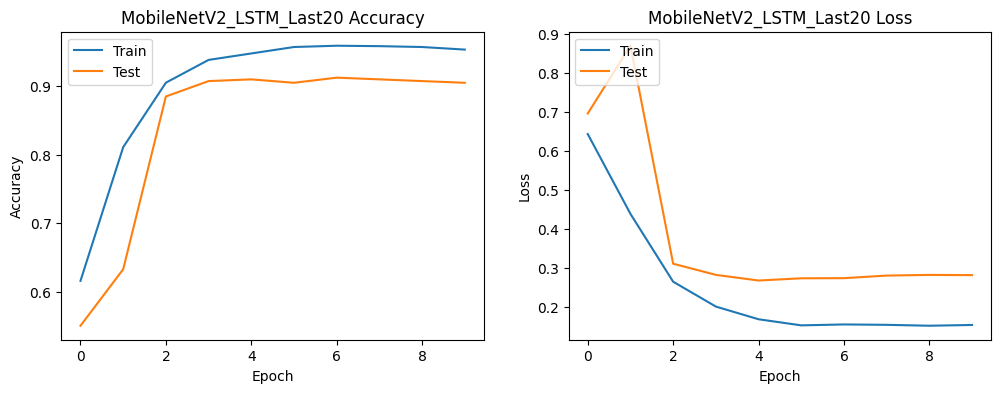






------------CLASSIFICATION REPORT & CONFUSION MATRIX: MobileNetV2_LSTM_Last20------------


Evaluating videos: 100%|██████████| 400/400 [02:56<00:00,  2.27it/s]

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       195
           1       0.93      0.90      0.91       205

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



<Figure size 2000x3000 with 0 Axes>

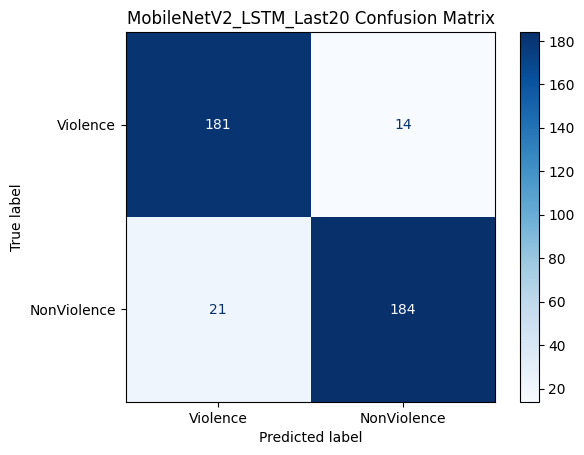






------------INFERENCE SUMMARY: MobileNetV2_LSTM_Last20------------
176.39 seconds


In [ ]:
print(f"------------EVALUATING MODEL: {model_name}------------")
evaluate_and_plot(mobileNetV2LSTM20, model_name, data_loader, mobileNetV2LSTM20_history, test_videos, test_labels)

print(f"\n\n\n\n\n------------CLASSIFICATION REPORT & CONFUSION MATRIX: {model_name}------------")
predict_and_print_reports(mobileNetV2LSTM20, model_name, data_loader, test_videos, test_labels)

# 4. Result Viz

In [2]:
data = {
  "accuracy": [78.75, 80.75, 80.5, 63.5, 74.25, 92, 92.25],
  "loss": [50.39, 44.47, 49.22, 62.82, 56.34, 24.03, 23.46],
  "precision": [0.87, 0.81, 0.75, 0.87, 0.78, 0.90, 0.91],
  "recall": [0.67, 0.78, 0.90, 0.30, 0.66, 0.94, 0.93],
  "f1-score": [0.75, 0.80, 0.82, 0.44, 0.71, 0.92, 0.92],
  "parameters": [33612418, 8668162, 2551386, 2029010, 3963810, 6992802, 6992802]
}

df = pd.DataFrame(data, index = ["base_model", "3D_conv_2", "cnn_lstm_1", "cnn_lstm_2", "cnn_bi_lstm", "mobileNetV2_lstm", "mobileNetV2_lstm_8Frames"])

df

,accuracy,loss,precision,recall,f1-score,parameters
base_model,78.75,50.39,0.87,0.67,0.75,33612418
3D_conv_2,80.75,44.47,0.81,0.78,0.80,8668162
cnn_lstm_1,80.50,49.22,0.75,0.90,0.82,2551386
cnn_lstm_2,63.50,62.82,0.87,0.30,0.44,2029010
cnn_bi_lstm,74.25,56.34,0.78,0.66,0.71,3963810
mobileNetV2_lstm,92.00,24.03,0.90,0.94,0.92,6992802
mobileNetV2_lstm_8Frames,92.25,23.46,0.91,0.93,0.92,6992802


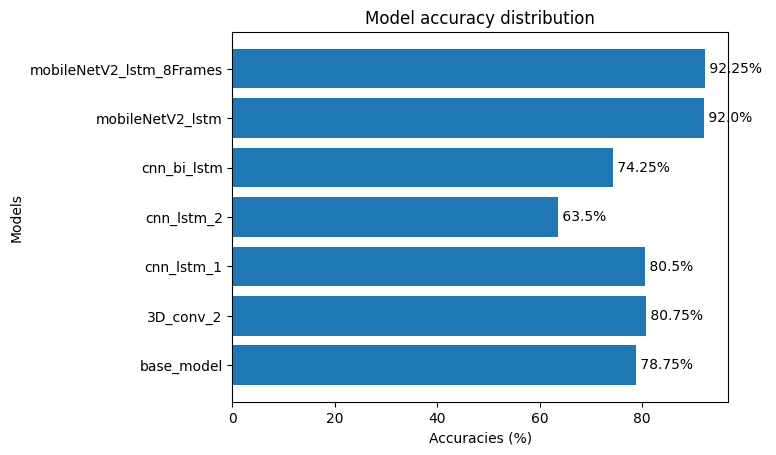

In [48]:
data = df["accuracy"].to_dict()

# Bar graph for video counts
bars = plt.barh(list(data.keys()), list(data.values()))
plt.ylabel('Models')
plt.xlabel('Accuracies (%)')
plt.title('Model accuracy distribution')

# plt.xticks(rotation=45)

# Annotate each bar with the count
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f" {xval}% ", va='center')

plt.show()

In [16]:
accuracy_without_transfer_learning = df.loc[["base_model", "3D_conv_2", "cnn_lstm_1", "cnn_lstm_2", "cnn_bi_lstm"], "accuracy"].values

accuracy_with_transfer_learning = df.loc[["mobileNetV2_lstm", "mobileNetV2_lstm_8Frames"], "accuracy"].values


# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(accuracy_without_transfer_learning, accuracy_with_transfer_learning)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.0663504740854646
P-value: 0.02789946554626835
